# 연구 설계

1. 1번 평정 점수 < 2번 평정 점수 일 때의 bold 변화
2. 1번 평정 점수 > 2번 평정 점수 일 때의 bold 변화

사진들의 종류

1. 선택 후 점수가 올라간 사진
2. 선택 후 점수가 변화없는 사진
3. 선택 후 점수가 내려간 사진
4. 미선택 후 점수가 올라간 사진
5. 미선택 후 점수가 변화없는 사진
6. 미선택 후 점수가 내려간 사진

for feature:

2번째 평정에서 cho_up에 해당하는  사진 번호 리스트화.

1번째 평정, 2번째 평정에서 해당 사진의 onset 가져오기.


1번째 평정시 bold 데이터에서 onset + 6초에 해당하는 bold값

2번째 평정시 bold 데이터에서 onset + 6초에 해당하는 bold값 가져오기.

이 값들을 feature로


for y:

1번째 평정 데이터들의 y = 0

2번째 평정 데이터들의 y = 1


이걸 rjc_down에서도 똑같이 한다.

+ 연결성에 대해서도 해보기.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
del feature_list, con_list, func_list, y_list, onset_bold_list, predicted_list, concated_list, final_onset_list

In [3]:
# confounds 불러오기
import pandas as pd
from nilearn import image

'''
'2207071', '2207141', '2207142', '2207143', '2207271', '2207272', '2207273',
          '2208041', '2208042', '2208043', '2208231', '2208232', '2208233', '2209022',
          '2209023', '2209222', '2209223', '2303101', '2303102', '2303103', '2303131',
          '2303132', '2303133', '2303161', '2303162', '2303163', '2303201', '2303202', '2303203'
'''

con_path = 'D:/fmri/3. derivatives 폴더에 넣어야 하는 것 (전처리 후 데이터, MNI 템플릿)/fmriprep/sub-ID{}/func/sub-ID{}_task-r{}_desc-confounds_timeseries.tsv'
base_path = 'D:/fmri/3. derivatives 폴더에 넣어야 하는 것 (전처리 후 데이터, MNI 템플릿)/fmriprep/sub-ID{}/func/sub-ID{}_task-r{}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'


sub_ids = ['2303163', '2303201', '2303202', '2303203']
r_nums = ['5','6','1','2']

feature_list = []

for sub_id in sub_ids:
    con_list = []
    func_list = []
    
    for r_num in r_nums:
        # confounds
        file_path = con_path.format(sub_id, sub_id, r_num)
        con = pd.read_csv(file_path, sep='\t')

        con1 = con.fillna(0)

        con_list.append(pd.DataFrame(con1))

        # bold
        func_path = base_path.format(sub_id, sub_id, r_num)
        data = image.load_img(func_path)
    
        func_list.append(data)

        # 전처리
    for i in range(len(func_list)):
        func_dc = image.clean_img(func_list[i], detrend=True, standardize=True, t_r=2,
                              confounds=con_list[i])
        feature_list.append(func_dc)
        



    

In [4]:
feature_list

1. 5,6 이벤트 파일 가져오기. 각각 cho_up에 해당하는 jpg번호 얻기, 해당 행만 남기기.
2. 5,6에서 해당하는 jpg번호를 1번 이벤트 파일과 대조. 같은 onset행만 남기고 없는 행은 버리기
3. 똑같이 2번 이벤트 파일과 대조. (1번 이벤트, 2번 이벤트 파일 따로 있어야 함.)

In [5]:
onset_path = 'D:/fmri/3. derivatives 폴더에 넣어야 하는 것 (전처리 후 데이터, MNI 템플릿)/fmriprep/sub-ID{}/eve_files/sub-ID{}_task-r{}_events.tsv'

from scipy.interpolate import interp1d
import numpy as np

r_nums = ['5','6','1','2']


y_list = []

for sub_id in sub_ids:
    onset_list = []
    cho_up_list = []
    original_scale = np.arange(0,550, 1)
    desired_scale = np.arange(0,550, 2)
    
    for r_num in r_nums:
        file_path = onset_path.format(sub_id, sub_id, r_num)
        onset_file = pd.read_csv(file_path, sep='\t')

        if r_num == '5' or r_num == '6':
            cho_up = onset_file[onset_file['chosen_change_detail'] == 'cho_up']
            onset_list.append(cho_up)

            events = cho_up['stim_onset'].values
            predictor_all = np.zeros(550, dtype=int)

            for i in [4,5]:
                events1 = events.astype(int) + i
                predictor_all[events1.astype(int)] = 1

            resampler = interp1d(original_scale, predictor_all)
            y = resampler(desired_scale)
            y_list.append(y)
            
        else:
            cho_up_jpg = pd.concat([onset_list[0]['stim'], onset_list[1]['stim']], axis=0)
            cho_1 = onset_file[onset_file['stim'].isin(cho_up_jpg.values)]
            cho_up_list.append(cho_1)

            events = cho_1['stim_onset'].values
            predictor_all = np.zeros(550, dtype=int)
            
            for i in [4,5]:
                events1 = events.astype(int) + i
                predictor_all[events1.astype(int)] = 1

            resampler = interp1d(original_scale, predictor_all)
            y = resampler(desired_scale)
            y_list.append(y)


In [6]:
len(y_list)

16

In [7]:
# 참가자의 onset때 bold추출
# y값도 같이 만들어주기.
import nibabel as nib

onset_bold_list = []
predicted_list = []

for i in range(len(feature_list)):
    fdata = feature_list[i].get_fdata()
    onset_indices = np.where(y_list[i] == 1)[0]
    
    bold_data = fdata[:,:,:,onset_indices]
    img = nib.Nifti1Image(bold_data, feature_list[i].affine)
    onset_bold_list.append(img)

    print('file shape :', onset_bold_list[i].shape)

    if (i+1) % 4 == 1 or (i+1) % 4 == 2:
        predicted = [1]*img.shape[3]
        predicted_list.append(predicted)

    else:
        predicted2 = [0]*img.shape[3]
        predicted_list.append(predicted2)

file shape : (65, 77, 65, 14)
file shape : (65, 77, 65, 15)
file shape : (65, 77, 65, 11)
file shape : (65, 77, 65, 18)
file shape : (65, 77, 65, 18)
file shape : (65, 77, 65, 7)
file shape : (65, 77, 65, 15)
file shape : (65, 77, 65, 10)
file shape : (65, 77, 65, 18)
file shape : (65, 77, 65, 18)
file shape : (65, 77, 65, 18)
file shape : (65, 77, 65, 18)
file shape : (65, 77, 65, 10)
file shape : (65, 77, 65, 9)
file shape : (65, 77, 65, 9)
file shape : (65, 77, 65, 10)


In [8]:
predicted_list

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [9]:
# r5,r6,r1,r2 합치기
from nilearn import image

concated_list = []
chunk_size=4

for j in range(0, len(onset_bold_list), chunk_size):
    bold_concated = image.concat_imgs(onset_bold_list[j:j+4])
    print(bold_concated.shape)
    concated_list.append(bold_concated)

(65, 77, 65, 58)
(65, 77, 65, 50)
(65, 77, 65, 72)
(65, 77, 65, 38)


In [10]:
# 메모리 위해 따로 저장
for i in range(len(concated_list)):
    output_path = f'D:/fmri/cho_up/ID{sub_ids[i]}_cho_up.nii.gz'
    print(f'the file name : ID{sub_ids[i]}_cho_up')
    print(f'the file shape : {concated_list[i].shape}')
    nib.save(concated_list[i], output_path)

the file name : ID2303163_cho_up
the file shape : (65, 77, 65, 58)
the file name : ID2303201_cho_up
the file shape : (65, 77, 65, 50)
the file name : ID2303202_cho_up
the file shape : (65, 77, 65, 72)
the file name : ID2303203_cho_up
the file shape : (65, 77, 65, 38)


In [11]:
# y 만들기..
chunk_size = 4

final_onset_list = []

for i in range(0, len(predicted_list), chunk_size):
    onset_y = np.concatenate(predicted_list[i:i+4])
    y = onset_y.ravel()
    print(y.shape)
    final_onset_list.append(y)

(58,)
(50,)
(72,)
(38,)


In [12]:
# 따로 저장
for i in range(len(final_onset_list)):
    output_y = pd.DataFrame({'R2=1' : final_onset_list[i]})
    output_y_path = f'D:/fmri/cho_up/y/ID{sub_ids[i]}_cho_up_y.csv'
    
    print(f'the file name : ID{sub_ids[i]}_cho_up_y')
    print(f'the file shape : {final_onset_list[i].shape}')
    
    output_y.to_csv(output_y_path, index=False)

the file name : ID2303163_cho_up_y
the file shape : (58,)
the file name : ID2303201_cho_up_y
the file shape : (50,)
the file name : ID2303202_cho_up_y
the file shape : (72,)
the file name : ID2303203_cho_up_y
the file shape : (38,)


In [9]:
# 마스크
t1 = image.load_img('D:/fmri/3. derivatives 폴더에 넣어야 하는 것 (전처리 후 데이터, MNI 템플릿)/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_T1w.nii.gz')
t1.shape

(96, 114, 96)

In [10]:
# resample
img_resampled = image.resample_to_img(t1, bold_concated)
img_resampled.shape

(65, 77, 65)

In [15]:
# from scipy.ndimage import binary_dilation

# 데이터를 200이상인 값은 1로, 그외의 값 0으로 변환. # 값은 계속 돌려가며 한번 보자.
data_binary = np.array(img_resampled.get_fdata()>=400, dtype=np.int8)

# Dilate binary mask once
# 이진화된 데이터 팽창작엄.(마스크 확장해서 뇌영상 데이터에서 원하는 복셀 더 포함)
# data_dialted = binary_dilation(data_binary, iterations=1).astype(np.int8)

# Save binary mask in NIfTI image
# img_mask = nb.Nifti1Image(data_dialted, img_resampled.affine, img_resampled.header)
brain_mask = nib.Nifti1Image(data_binary, img_resampled.affine, img_resampled.header)
brain_mask.set_data_dtype('i1')

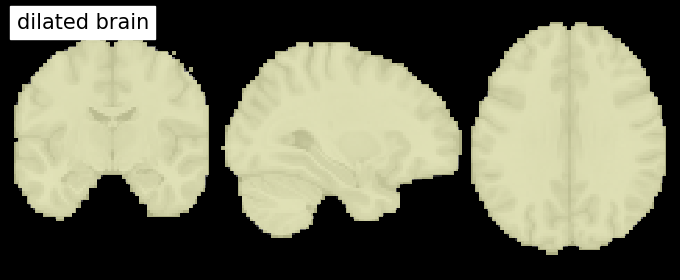

In [16]:
from nilearn.plotting import plot_roi
plot_roi(brain_mask, draw_cross=False, annotate=False, black_bg=True,
        bg_img=t1, cut_coords=[30,-10,30], title='dilated brain', cmap='magma_r', dim=1)

In [17]:
from nilearn import masking

X = masking.apply_mask(bold_concated, brain_mask)
print('Shape of indexed data:', X.shape)

Shape of indexed data: (54, 72382)


In [18]:
# y 만들기..
onset_y = np.concatenate(predicted_list)
y = onset_y.ravel()
y.shape

(54,)

In [25]:
output_y = pd.DataFrame({'R2=1' : y})
output_y_path = f'D:/fmri/cho_up/y/ID{sub_ids[0]}_cho_up_y.csv'

output_y.to_csv(output_y_path, index=False)

In [85]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (54, 72382)
y shape: (54,)


# 간단하게 로지스틱 해보겠어요

In [88]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

In [95]:
clf.fit(X_train, y_train)

LogisticRegression()

In [96]:
pred = clf.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

confusion = confusion_matrix(y_test, pred)
accuracy = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)

print('혼동행렬 : \n',
      confusion)
print(f"정화도 : {accuracy:.4f}, 민감도 : {recall:.4f}, 정밀도 : {precision:.4f}")

혼동행렬 : 
 [[9 3]
 [8 7]]
정화도 : 0.5926, 민감도 : 0.4667, 정밀도 : 0.7000
